In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns
import requests
from pandas.io.json import json_normalize
from sklearn import linear_model
from scipy.stats import norm

In [2]:
# Get authorization

# Fetch records 
url = 'https://d0b77340-7ed9-4ca4-9a35-2cbec92e73b1.app.jexia.com/ds/homeprices_training_data'
headers = {'Content-Type': 'application/json',
          'Authorization':''}
r = requests.get(url, headers = headers)

# Load training data
training_data = json_normalize(r.json())
training_data = training_data.drop(['id','created_at', 'updated_at'], axis = 1) 

# Remove outliers
training_data = training_data[
    (training_data.price > 0) 
    & (training_data.price < 2500) 
    & (training_data.area > 0)
    & (training_data.area < 200)]

training_data.tail(3)

,area,bedroom,price
136,45,1,1400
137,55,1,1400
138,88,2,1600


In [3]:
# Feature importance (by Random Forest Regressor)
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

y = training_data['price']
x = training_data.drop('price', axis =1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=1)
rf = RandomForestRegressor(n_estimators=500, 
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1)
rf.fit(X_train, y_train)
# y_train_pred = rf.predict(X_train)
# y_test_pred = rf.predict(X_test)
# rmse_rf= (mean_squared_error(y_test,y_test_pred))**(1/2)

# print('RMSE test: %.3f' % rmse_rf)
# print('R^2 test: %.3f' % (r2_score(y_test, y_test_pred)))

coefs_df = pd.DataFrame()
coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = rf.feature_importances_
coefs_df.sort_values('coefs', ascending=False).head(20)


,est_int,coefs
0,area,0.966537
1,bedroom,0.033463


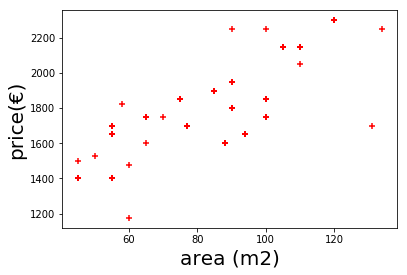

In [4]:
# Plot training data
%matplotlib inline
plt.xlabel('area (m2)', fontsize=20)
plt.ylabel('price(€)', fontsize=20)
plt.scatter(training_data.area, training_data.price, color='red', marker='+')
# plt.plot(training_data.area, training_data.price, color='blue')


Total: 89


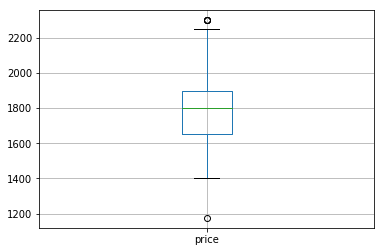

In [5]:
# Plot Median Values for price
price_array = np.array(training_data.price)

df = pd.DataFrame(price_array, columns=['price'])
df.plot.box(grid=True)
print('Total: %i' % df['price'].count())

# Median
# The median is the value separating the higher half of a data sample, a population, or a probability distribution, from the lower half. 

# Quartile
# The first quartile is defined as the middle number between the smallest number and the median of the data set. The second quartile is the median of the data. The third quartile is the middle value between the median and the highest value of the data set.

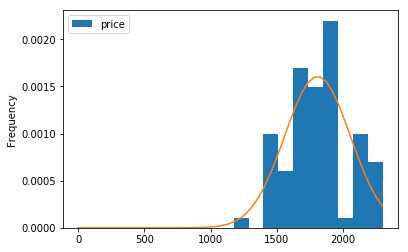

In [6]:
# Plot normal distribution
df.plot(kind='hist', density=True)

x = np.linspace(0, df.max())
plt.plot(x, norm.pdf(x, np.mean(price_array), np.std(price_array)))
plt.show()

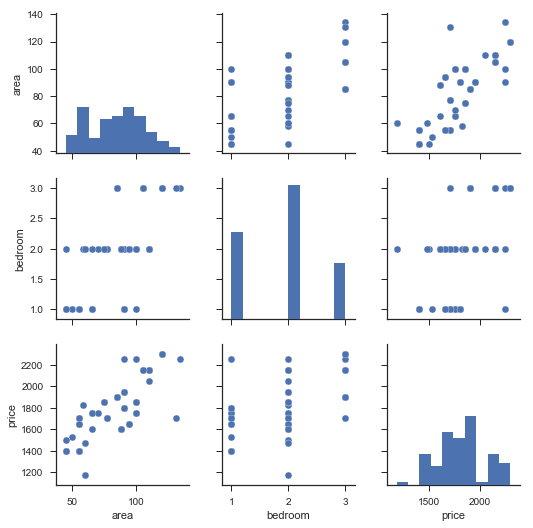

In [7]:
# Explore features together
features = ['bedroom', 'area']
sns.set(style="ticks", color_codes=True)
sns.pairplot(training_data)
plt.show();

In [8]:
# Training linear regression model with 'area' training data points
reg = linear_model.LinearRegression()
reg.fit(training_data[['area']], training_data.price)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [9]:
# Predict price according single m2 (x area)

# In regression problems we trying to predict continuous valued output.
# Linear regression is used to predict a quantitative response Y from the predictor variable X.
# Linear Regression is made with an assumption that there’s a linear relationship between X and Y.
# We know the given eqaution y=mx+b represents a straight line with slope m and the y intercept b.
# y=m*x+b

# "m" represents the "slope" of the line. This is rise/run. 
# reg.coef_

# "b" represents the "y-intercept" of the line. This is where the line cross es the y-axis (the part of the coordinate grid that goes up and down).
# reg.intercept_

# print(reg.coef_*100+reg.intercept_)
print('A house with 100 m2 can be rent for € %i' % reg.predict(100))

A house with 100 m2 can be rent for € 1956


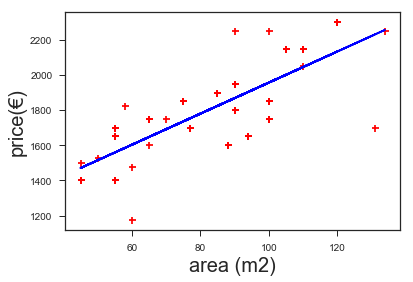

In [10]:
# Ploting all price prediction according area training data
plt.xlabel('area (m2)', fontsize=20)
plt.ylabel('price(€)', fontsize=20)
plt.scatter(training_data.area, training_data.price, color='red', marker='+')
plt.plot(training_data.area, reg.predict(training_data[['area']]), color='blue')


In [12]:
# After trained, make prediction...

print('Houses between 100 and 200 m2 can be rent for:')
prediction_data = pd.DataFrame([
    [100], 
    [150], 
    [200]
], columns=['area'])
prediction_data['price'] = reg.predict(prediction_data)
print(prediction_data)


Houses between 100 and 200 m2 can be rent for:
   area        price
0   100  1956.360247
1   150  2397.878087
2   200  2839.395926
